In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import random
from bs4 import BeautifulSoup
import scipy.optimize as sco
import re
import pandas as pd
import scipy.optimize as opt

In [2]:
# #爬蟲取得加權指數資料
# start_date = '2018-01-01'
# end_date = '2021-12-31'

# resp = requests.get(f'https://api.finmindtrade.com/api/v3/data?dataset=TaiwanStockPrice&date={start_date}&end_date={end_date}&stock_id=TAIEX')
# TAIEX_data = resp.json()['data']
# TAIEX_data = pd.DataFrame(TAIEX_data)
# TAIEX_data['daily_return'] = TAIEX_data.close / TAIEX_data.close.shift(1) - 1

# TAIEX_data

In [3]:
#讀取上市普通股股價與加權指數資料
data = pd.read_csv('data.csv', encoding='utf-16', sep='\t')
data['證券代碼'] = data['證券代碼'].str.split(' ').str[0]
data

證券代碼  TSE 產業別     TEJ產業名     TSE新產業名       年月日    收盤價(元)    報酬率％  \
0         1101      1.0  M11A 水泥製造  M1100 水泥工業  20180102     36.55  0.2743   
1         1102      1.0  M11A 水泥製造  M1100 水泥工業  20180102     28.20  0.0000   
2         1103      1.0  M11A 水泥製造  M1100 水泥工業  20180102     13.45  0.7491   
3         1104      1.0  M11A 水泥製造  M1100 水泥工業  20180102     23.00  0.2179   
4         1108      1.0  M11A 水泥製造  M1100 水泥工業  20180102      8.40  0.3584   
...        ...      ...        ...         ...       ...       ...     ...   
1149004   9946     14.0    M25A 建設  M2500 建材營造  20221230     12.20  0.4115   
1149005   9955     35.0  M99L 資源回收  M2335 綠能環保  20221230     19.80 -0.5025   
1149006   9958     10.0  M20A 金屬基本  M2000 鋼鐵工業  20221230     88.60 -2.4229   
1149007  Y9997      NaN        NaN         NaN  20221230  29388.80  0.3739   
1149008  Y9999      NaN        NaN         NaN  20221230  14137.70  0.3739   

          市值(百萬元)  
0          155209  
1           94792  
2           10420  
3           15033  
4            3399  
...           ...  
1149004      3984  
1149005      2044  
1149006     20590  
1149007  44062594  
1149008  44062594  

[1149009 rows x 8 columns]

In [4]:
#將dataframe依照年月日切割，存入dict, ex. data_of_the_date[20190102]可取出當天的資料
data_of_the_date = {}
for i in range(0, len(data)):
    if data['年月日'][i] not in data_of_the_date:
        data_of_the_date[data['年月日'][i]] = data.iloc[i:i+1]
    else:
        data_of_the_date[data['年月日'][i]] = pd.concat([data_of_the_date[data['年月日'][i]], data.iloc[i:i+1]])

for i in data_of_the_date:
    data_of_the_date[i] = data_of_the_date[i].reset_index(drop=True)

In [5]:
#找出所有產業類型
industrys = data['TSE新產業名'].unique()
#移除nan
industrys = industrys[~pd.isna(industrys)]
industrys

array(['M1100 水泥工業', 'M1200 食品工業', 'M1300 塑膠工業', 'M2500 建材營造',
       'M2200 汽車工業', 'M1400 紡織纖維', 'M9900 其他', 'M3700 運動休閒',
       'M2328 電子零組件', 'M1500 電機機械', 'M1600 電器電纜', 'M1722 生技醫療',
       'M1721 化學工業', 'M1800 玻璃陶瓷', 'M1900 造紙工業', 'M2000 鋼鐵工業',
       'M3800 居家生活', 'M2100 橡膠工業', 'M2600 航運業', 'M2325 電腦及週邊',
       'M2324 半導體', 'M2331 其他電子業', 'M2327 通信網路業', 'M2326 光電業',
       'M2329 電子通路業', 'M2330 資訊服務業', 'M2900 貿易百貨', 'M9700 油電燃氣業',
       'M2700 觀光餐旅', 'M2800 金融業', 'M2336 數位雲端', 'M2335 綠能環保',
       'W91   存託憑證'], dtype=object)

In [6]:
#計算該年度各產業在市場的比重
def get_industrys_weight(data, year):
    start_date = year + '0101'
    end_date = year + '1231'
    filtered_data = data[(data['年月日'] >= int(start_date)) & (data['年月日'] <= int(end_date))]
    industrys_marketValue = filtered_data.groupby('TSE新產業名').sum()['市值(百萬元)']
    industrys_weight = industrys_marketValue / industrys_marketValue.sum()
    return industrys_weight

In [16]:
#定義選取股票的函數，依照各產業中所佔比重選取股票

def get_n_stocks(data, year, n):
    industrys_weight = get_industrys_weight(data, year)
    #算出各產業要選幾隻股票
    n_stocks = (industrys_weight * n)
    n_stocks = n_stocks.astype(int)

    #找出所有產業類型
    if year == '2022':
        filter_data = data[data['年月日'] == int(year + '0103')]
    elif year == '2021':
        filter_data = data[data['年月日'] == int(year + '0104')]
    else:
        filter_data = data[data['年月日'] == int(year + '0102')]
    industrys = filter_data['TSE新產業名'].unique()
    #移除nan產業
    industrys = industrys[~pd.isna(industrys)]
    

    #紀錄不足的股票產業
    insufficient_industrys = []
    for industry in industrys:
        if n_stocks[industry] > len(filter_data[filter_data['TSE新產業名'] == industry]['證券代碼'].unique()):
            print(industry, f'產業股票數量不足需求{n_stocks[industry]}隻，只有{len(filter_data[filter_data["TSE新產業名"] == industry]["證券代碼"].unique())}隻')
            n_stocks[industry] = len(filter_data[filter_data['TSE新產業名'] == industry]['證券代碼'].unique())
            insufficient_industrys.append(industry)
    print('不足的產業有', insufficient_industrys)


    while n_stocks.sum() != n:
        #從充足的產業中隨機挑一個，增加一隻股票
        industry = random.choice(list(set(industrys) - set(insufficient_industrys)))
        #如果該產業股票數量已經達到上限，則跳過
        if n_stocks[industry] == len(filter_data[filter_data['TSE新產業名'] == industry]['證券代碼'].unique()):
            continue
        n_stocks[industry] += 1
            

    #從上面算出的產業股票數量中，從該產業市值最大的股票開始選
    selected_stocks = []
    for industry in n_stocks.index:
        filtered_data = data[data['TSE新產業名'] == industry]
        if year == '2022':
            filtered_data = filtered_data[filtered_data['年月日'] == int(year + '0103')]
        elif year == '2021':
            filtered_data = filtered_data[filtered_data['年月日'] == int(year + '0104')]
        else:
            filtered_data = filtered_data[filtered_data['年月日'] == int(year + '0102')]
        filtered_data = filtered_data.sort_values(by='市值(百萬元)', ascending=False)
        selected_stocks += list(filtered_data['證券代碼'].head(n_stocks[industry]))
    print('選出的股票數量為', len(selected_stocks))

    return selected_stocks

def get_n_stocks_by_value(data, year, n):
    if year == '2022':
        filter_data = data[(data['年月日'] == int(year + '0103')) & (data['證券代碼'] != 'Y9999') & (data['證券代碼'] != 'Y9997')]
    elif year == '2021':
        filter_data = data[(data['年月日'] == int(year + '0104')) & (data['證券代碼'] != 'Y9999') & (data['證券代碼'] != 'Y9997')]
    else:
        filter_data = data[(data['年月日'] == int(year + '0102')) & (data['證券代碼'] != 'Y9999') & (data['證券代碼'] != 'Y9997')]

    filter_data = filter_data.sort_values(by='市值(百萬元)', ascending=False)
    selected_stocks = list(filter_data['證券代碼'].head(n))
    print('選出的股票數量為', len(selected_stocks))
    return selected_stocks
        

In [17]:
year = '2020'
start_day = int(str(year) + '0101')
end_day = int(str(year) + '1231')

stocks400_list = get_n_stocks_by_value(data, year, 400)
stocks300_list = get_n_stocks_by_value(data, year, 300)
stocks250_list = get_n_stocks_by_value(data, year, 250)

選出的股票數量為 400
選出的股票數量為 300
選出的股票數量為 250


In [18]:
#算權重
def get_weight(daily_data):
    stock_and_weight = {}
    total_value = daily_data['市值(百萬元)'].sum()
    for i in range(len(daily_data)):
        stock_and_weight[daily_data['證券代碼'][i]] = daily_data['市值(百萬元)'][i]/total_value
    return stock_and_weight

# # 使用範例
# get_weight(data_of_the_date[20190102])

In [19]:
import datetime

def get_month(date_intstring):
    date = datetime.datetime.strptime(str(date_intstring).split('\n')[0].strip(), '%Y%m%d')
    return date.month

def convert_to_minguo_date(date_str):
    date_obj = datetime.datetime.strptime(str(date_str), '%Y%m%d')
    minguo_year = date_obj.year - 1911
    minguo_date_str = date_obj.strftime(f"{minguo_year}%m%d")
    return minguo_date_str

def convert_format_to_float(s):
    s_without_commas = s.replace(',', '')
    s_as_integer = float(s_without_commas)
    return s_as_integer


In [11]:
def get_stockDailyReturn_by_date(stock, date, stock_price):
    result_df = stock_price[stock_price['年月日'] == int((date))]
    try:
        daily_return = (float(result_df['報酬率％'])) / 100
    except Exception as e:
        print(f'股票:{stock} 在{date}計算日報酬時出現錯誤：' + str(e))
        daily_return = 0
    return daily_return * 100

# #使用範例
# get_stockDailyReturn_by_date(2330, 20200106, stock_price_dict['2330'])
    

In [12]:
def get_stock_prices(data, stock_list, year):
    last_year = str(int(year) - 1)
    result_dict = {}
    start_date = last_year + '0101'
    end_date = year + '1231'
    for stock in stock_list:
        result = data[(data['證券代碼'] == stock) & (data['年月日'] >= int(start_date)) & (data['年月日'] <= int(end_date))]
        result_dict[stock] = result
    return result_dict
    

In [13]:
def tracking(start_date, end_date, data_of_the_date, data, stock_price_dict, stocks_list):
    year = int(str(start_date)[:4])
    daily_data_of_portfolio = next((value for key, value in data_of_the_date.items() if str(key).startswith(str(year))), None)
    daily_data_of_portfolio = daily_data_of_portfolio[daily_data_of_portfolio['證券代碼'].isin(stocks_list)]
    daily_data_of_portfolio.reset_index(drop=True, inplace=True)
    weight = get_weight(daily_data_of_portfolio)
    weights = []
    
    day_list = list(data['年月日'])
    day_set = sorted(set(day_list))
    portfolio_daily_return = []
    change = True
    last_month = 0
    temp_weight_combination = weight
    for idx, day in enumerate(day_set):
        if int(day) < int(start_date) or int(day) > int(end_date):
            continue
        if day not in data_of_the_date:
            continue

        #判斷該日該採用哪個調整參考月的權重
        month = get_month(day)
        last_month = month - 1
        quarter = (month - 1) // 3 + 1
        weight_combination = weight
        stocks = weight_combination.keys()
        if last_month in [3, 6, 9, 12] and get_month(int(day_set[idx-1])) != get_month(int(day)):
            change = True

        if change == False:
            daily_return = 0
            for stock in stocks:
                daily_return += get_stockDailyReturn_by_date(int(stock), int(day), stock_price_dict[str(stock)]) * weight_combination[stock]
            portfolio_daily_return.append(daily_return)
            temp_weight_combination = weight_combination
            print(f'權重發生變更：')
            print(temp_weight_combination)
            change = False
        else:
            daily_return = 0
            new_weight = {}
            total_weight = 0
            for stock in weight_combination:
                total_weight += ((get_stockDailyReturn_by_date(int(stock), int(day), stock_price_dict[str(stock)])/100 + 1) * temp_weight_combination[stock])
            for stock in weight_combination:
                new_weight[stock] = ((get_stockDailyReturn_by_date(int(stock), int(day), stock_price_dict[str(stock)])/100 + 1) * temp_weight_combination[stock]) / total_weight
            for stock in weight_combination:
                daily_return += get_stockDailyReturn_by_date(int(stock), int(day), stock_price_dict[str(stock)]) * temp_weight_combination[stock]
            temp_weight_combination = new_weight
            portfolio_daily_return.append(daily_return)  
        print(temp_weight_combination)   

    return portfolio_daily_return
    

In [14]:
def get_stock_price_dict(stock_list):
    stock_price_dict = {}
    for stock in stock_list:
        last_year = str(int(str(start_day)[:4]) - 1)
        last_start_day = last_year + '0101'
        stock_price_dict[str(stock)] = data[ (data['證券代碼'] == stock) & (data['年月日'] >= int(last_start_day)) & (data['年月日'] <= int(end_day))].reset_index(drop=True)
        stock_price_dict[str(stock)] = stock_price_dict[str(stock)].reset_index(drop=True)
    return stock_price_dict

In [20]:
tracking_return_400 = tracking(start_day, end_day, data_of_the_date, data, get_stock_price_dict(stocks400_list), stocks400_list)
tracking_return_300 = tracking(start_day, end_day, data_of_the_date, data, get_stock_price_dict(stocks300_list), stocks300_list)
tracking_return_250 = tracking(start_day, end_day, data_of_the_date, data, get_stock_price_dict(stocks250_list), stocks250_list)

{'1101': 0.006986112559603569, '1102': 0.004814554850479064, '1103': 0.000497333635389924, '1104': 0.0003698053689686372, '1110': 0.00028339416860789475, '1201': 0.00036699196129571333, '1210': 0.001015936527523369, '1215': 0.0005095400800099701, '1216': 0.012108965389362687, '1218': 0.0003202461987756816, '1227': 0.0017667134427208453, '1229': 0.0011819400709514088, '1232': 0.0005651810321083814, '1234': 0.000379162434069164, '1301': 0.018173454723079463, '1303': 0.016491519526597605, '1304': 0.0004831811586624104, '1305': 0.00032554072457059415, '1307': 0.0002736554506348526, '1308': 0.0002547783729857141, '1310': 0.0003183858110471728, '1312': 0.0005134000260533999, '1313': 0.00042860205460200015, '1314': 0.0007881619567724567, '1315': 0.00026925980779513383, '1319': 0.0007941831898587402, '1321': 0.00027193830576372835, '1326': 0.014797113527106765, '1402': 0.004604531853592229, '1409': 0.0005835826435512116, '1419': 0.0003593577296141562, '1434': 0.0016644696514955901, '1440': 0.0

In [23]:
def get_assets_growth(daily_return):
    assets_growth = []
    for i in range(len(daily_return)):
        if i == 0:
            assets_growth.append(100)
        else:
            assets_growth.append(assets_growth[i-1] * (1 + daily_return[i]/100))
    return assets_growth

In [24]:
#取出該期間TAIEX的日報酬
TAIEX_daily_return = []
TAIEX_data = data[(data['證券代碼'] == 'Y9999') & (data['年月日'] >= int(start_day)) & (data['年月日'] <= int(end_day))]
TAIEX_data.reset_index(drop=True, inplace=True)
for i in range(len(TAIEX_data)):
    TAIEX_daily_return.append(TAIEX_data['報酬率％'][i])
len(TAIEX_daily_return)

245

加權指數報酬：21.75082172166214%
追蹤400報酬：26.087728008608213%
追蹤300報酬：26.28226363373516%
追蹤250報酬：26.341875719576045%


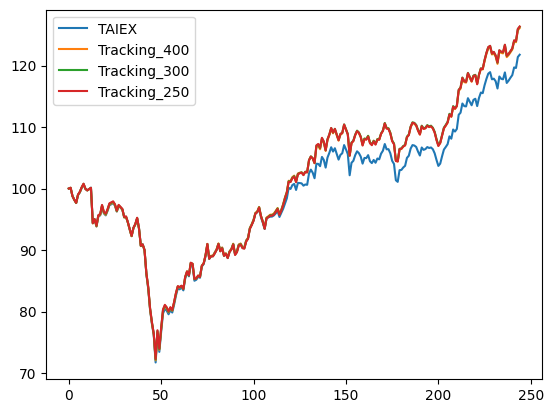

In [25]:
#畫出台50指成長曲線
import matplotlib.pyplot as plt

print(f'加權指數報酬：{(get_assets_growth(TAIEX_daily_return)[-1]/get_assets_growth(TAIEX_daily_return)[0] - 1)*100}%')
print(f'追蹤400報酬：{(get_assets_growth(tracking_return_400)[-1]/get_assets_growth(tracking_return_400)[0] - 1)*100}%')
print(f'追蹤300報酬：{(get_assets_growth(tracking_return_300)[-1]/get_assets_growth(tracking_return_300)[0] - 1)*100}%')
print(f'追蹤250報酬：{(get_assets_growth(tracking_return_250)[-1]/get_assets_growth(tracking_return_250)[0] - 1)*100}%')

plt.plot(get_assets_growth(TAIEX_daily_return), label='TAIEX')
plt.plot(get_assets_growth(tracking_return_400), label='Tracking_400')
plt.plot(get_assets_growth(tracking_return_300), label='Tracking_300')
plt.plot(get_assets_growth(tracking_return_250), label='Tracking_250')




plt.legend()

In [26]:
def get_tracking_error(tracking_return, index50_daily_return):
    dif = []
    for i in range(len(tracking_return)):
        dif.append(tracking_return[i] - index50_daily_return[i])
    return np.array(dif).std() * np.sqrt(len(tracking_return))

In [27]:
print(f'400 stocks tracking error: {get_tracking_error(tracking_return_400, TAIEX_daily_return).round(3)}%')
print(f'300 stocks tracking error: {get_tracking_error(tracking_return_300, TAIEX_daily_return).round(3)}%')
print(f'250 stocks tracking error: {get_tracking_error(tracking_return_250, TAIEX_daily_return).round(3)}%')

400 stocks tracking error: 0.973%
300 stocks tracking error: 1.252%
250 stocks tracking error: 1.463%


In [28]:
import pandas as pd


df = pd.DataFrame()

day_list = list(TAIEX_data['年月日'])
day_set = sorted(set(day_list))
#轉乘str
day_set = [str(day) for day in day_set if int(day) >= start_day and int(day) <= end_day]


df['日期'] = pd.to_datetime(day_set).strftime('%Y%m%d')
df['TAIEX日報酬%'] = TAIEX_daily_return
df['400追蹤日報酬%'] = tracking_return_400
df['300追蹤日報酬%'] = tracking_return_300
df['250追蹤日報酬%'] = tracking_return_250



df.to_csv(f'{str(start_day)[:4]}_top_tracking_difference.csv', encoding='utf-16', sep='\t', index=False)

============================================================================================================================